# Отчет по лабораторной работе 1.2

## Исследование эффекта комптона
Конкс Эрик, Б01-818

### Результат измерения и обработка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy import odr

degrees = [i * 10 for i in range(13)]
N = [584, 571, 552, 465, 435, 360, 323, 290, 259, 228, 219, 191, 175]
pd.DataFrame({'θ, °': degrees, 'N': N}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
"θ, °",0,10,20,30,40,50,60,70,80,90,100,110,120
N,584,571,552,465,435,360,323,290,259,228,219,191,175


In [2]:
x = 1 - np.cos(np.radians(degrees))
x_error = np.radians(2) * np.sin(np.radians(degrees))
x_error[0] = np.radians(2) * np.sin(np.radians(1))
y = np.divide(1, N)
y_error = np.divide(1, np.multiply(N, N))
pd.DataFrame({'1-cos(θ)': x, 'Δ(1-cos(θ))': x_error, '1/N': y, 'Δ(1/N)': y_error})

,1-cos(θ),Δ(1-cos(θ)),1/N,Δ(1/N)
0,0.000000,0.000609,0.001712,0.000003
1,0.015192,0.006061,0.001751,0.000003
2,0.060307,0.011939,0.001812,0.000003
3,0.133975,0.017453,0.002151,0.000005
4,0.233956,0.022438,0.002299,0.000005
5,0.357212,0.026740,0.002778,0.000008
6,0.500000,0.030230,0.003096,0.000010
7,0.657980,0.032801,0.003448,0.000012
8,0.826352,0.034376,0.003861,0.000015
9,1.000000,0.034907,0.004386,0.000019


In [3]:
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [18, 14]

$$\frac{1}{N(\theta)}-\frac{1}{N(0)}=A(1-cos\theta)$$

$$a=A$$

$$b=\frac{1}{N(0)}$$

In [4]:
f = lambda p, x: p[0] * x + p[1]


quad_model = odr.Model(f)
data = odr.RealData(x, y, sx=x_error, sy=y_error)
modr = odr.ODR(data, quad_model, beta0=[0., 1.])
out = modr.run()
beta_opt = out.beta
beta_err = out.sd_beta
beta_name = ['a', 'b']
print('Fit parameter 1-sigma error y = a * x + b')
print('———————————–—————————————————————————————')
for i in range(len(beta_opt)):
    print(f"{beta_name[i]} = {beta_opt[i]} +- {beta_err[i]}")

Fit parameter 1-sigma error y = a * x + b
———————————–—————————————————————————————
a = 0.002632828124252412 +- 4.0435262745963565e-05
b = 0.0017121631883070768 +- 4.174453443589273e-06


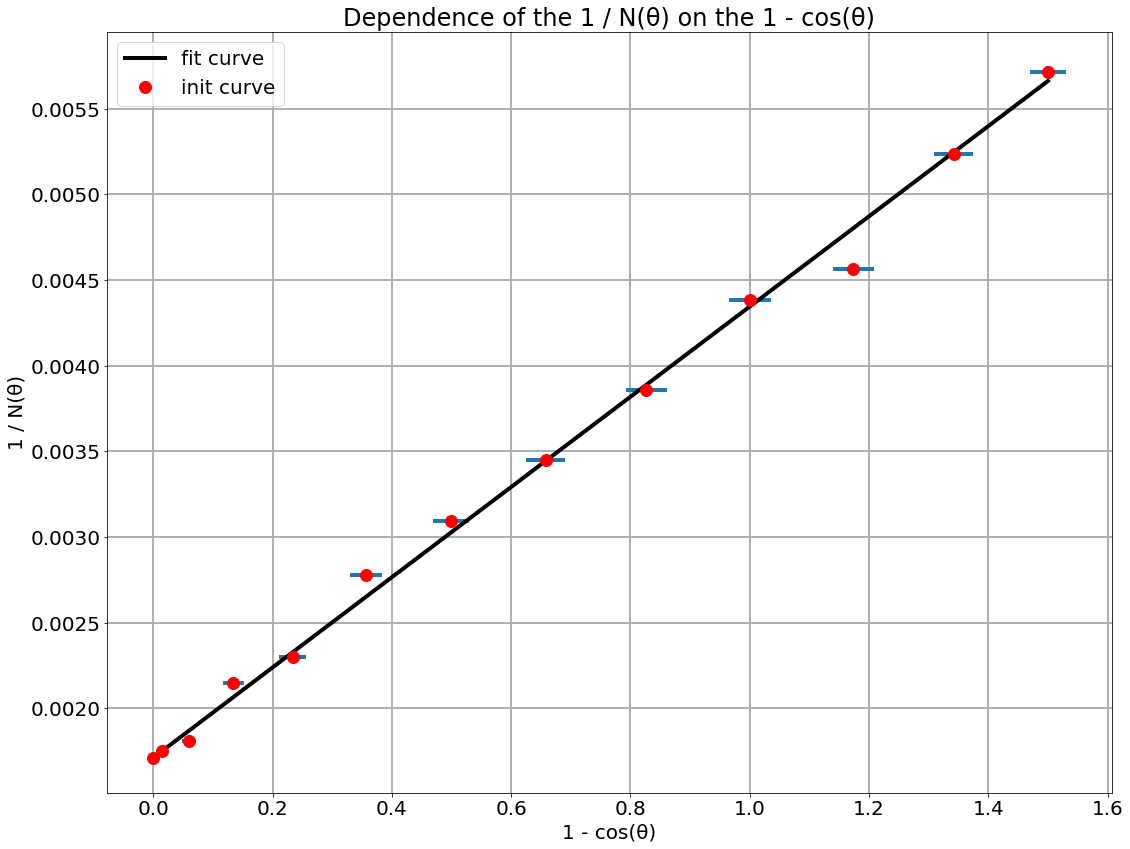

In [12]:
plt.plot(x, f(beta_opt, x), color='black', linewidth=4, label='fit curve')
plt.plot(x, y, 'ro', label='init curve', markersize=12)
plt.errorbar(x, y, xerr=x_error, yerr=y_error, fmt="none", linewidth=4)
plt.xlabel('1 - cos(θ)')
plt.ylabel('1 / N(θ)')
plt.grid(linewidth=2)
plt.legend()
plt.title('Dependence of the 1 / N(θ) on the 1 - cos(θ)')
plt.show()

In [6]:
N0 = 1 / beta_opt[1]
N0_err = beta_err[1] * 1 / beta_opt[1] ** 2
N90 = 1 / f(beta_opt, 1-np.cos(np.radians(90)))
N90_err1 = beta_err[0] * 1 / f(beta_opt, 1-np.cos(np.radians(90))) ** 2
N90_err2 = N0_err
N90_err = N90 * (N90_err1 + N90_err2) / (N90 + N0)

$$mc^2=E_\gamma\frac{N(90)}{N(0)-N(90)}$$

In [7]:
Eγ = 662
mc2 = Eγ * N90 / (N0 - N90)
mc2_err = mc2 * (N90_err / N90 + (N0_err + N90_err) / (N0 - N90))
print('Result')
print('———————————–———————————————————————————————————————')
print(f"mc^2 = {mc2} +- {mc2_err} кэВ")
print(f"mc^2 = {int(np.round(mc2))} +- {int(np.round(mc2_err))} кэВ")
print("mc^2 theoretically = 511 кэВ")

Result
———————————–———————————————————————————————————————
mc^2 = 430.50741528413556 +- 4.8437244659165195 кэВ
mc^2 = 431 +- 5 кэВ
mc^2 theoretically = 511 кэВ
